In [57]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-01 14:52:17
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

##################### Could be changed part ##########################
sparse_folder = 'results_primary_news_sparse_multiyears/'
index_folder = 'results_primary_news_index_multiyears/'

sparse_file = '2005_2020_sparse/2005_2014_sparse_threecol.csv'
index_file = '2005_2020_index_news/2005_2014_index_news.csv'
word_file = '2005_2014_stemmed_word_count.csv'

sparse_file0 = '2005_2020_sparse/2015_2019_sparse_threecol.csv'
index_file0 = '2005_2020_index_news/2015_2019_index_news.csv'


sparse_file1 = '2005_2020_sparse/2020_2020_sparse_threecol.csv'
index_file1 = '2005_2020_index_news/2020_2020_index_news.csv'

######################################################################

######################## Could be put in the function module py file ########################
# Define a function to transform data from three columns to sparse matrix
def trans_data(sparse_data, news_data, word_data):
    '''
    :param sparse_data: the three column saved words DataFrame includes 'Row', 'Column', 'Value'
    :param news_data: news DataFrame includes 'Row_ID', 'permno', 'returnday_1', 'threedayreturn', 'title'
    :param word_data: words DataFrame includes 'WordIndex', 'final_word', 'TotalWordNum', 'TotalBodyNum'

    :return W_array: sparse matrix of word counts, n*k --> n: # of news, k: # of words
    :return r_array: return vector, length == # of news
    :return stkcd_array: permno vector, length == # of news
    :return date_array: date vector, length == # of news
    '''
    if 'return' in news_data.columns :
        r_array = np.array(news_data['return'])
        date_array = np.array(news_data['returnday'])
    else:  
        r_array = np.array(news_data['threedayreturn'])
        date_array = np.array(news_data['returnday_1'])
    stkcd_array = np.array(news_data['permno'])
    
    
    # Transform three columns to sparse matrix W
    newrowarray = np.array(sparse_data['Row'])
    newcolarray = np.array(sparse_data['Column'])
    newvaluearray = np.array(sparse_data['Value'])

    W_array = sparse.csr_matrix((newvaluearray, (newrowarray, newcolarray)), shape = (newrowarray[-1]+1, word_data.shape[0])).toarray()

    return W_array, r_array, stkcd_array, date_array

#############################################################################################

# Load in data set
df_sparse = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file)
df_newsindex = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file)
df_words = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + word_file)
df_words = df_words.dropna().reset_index(drop = True).reset_index()

df_sparse0= pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file0)
df_newsindex0 = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file0)


df_sparse1= pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file1)
df_newsindex1 = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file1)

W_train, r_train, stkcd, datearray = trans_data(df_sparse, df_newsindex, df_words)
W_vali, r_vali, stkcd0, datearray0 = trans_data(df_sparse0, df_newsindex0, df_words)
W_test, r_test, stkcd1, datearray1 = trans_data(df_sparse1, df_newsindex1, df_words)



In [58]:
W_vali.shape

(108263, 23244)

In [38]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-04 22:31:35
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''

import heapq
from collections import Counter

def SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa):
    n, S = W_train.shape

    ###################Screening Part##############
    #####each year have appearance_word list#####
    # appearance_word = df_words.TotalBodyNum
    appearance_word = sum(W_train>0)
    print(np.quantile(appearance_word,kappa))

    # appearance_word = df_words.TotalBodyNum
    yearcount = dict(Counter([datearray[i][:4] for i in range(n)]))
    start = 0
    freq_index = []
    # for key, value in yearcount.items():
    #     print(key, value)
    #     appearance_word0 = sum(W_train[start:start + value]>0)
    #     # freq_index = list({np.where(appearance_word0 > np.quantile(appearance_word0, kappa))[0]}.union(freq_index))
    #     print('print(np.quantile(appearance_word,kappa))',np.quantile(appearance_word0,kappa))
    #     freq_index =list(set(np.where(appearance_word0 >= np.quantile(appearance_word0,kappa))[0]).union(set(freq_index)))
    #     # print(len(appearance_word0),len(freq_index))
    #     start += value
    #         # print(len(freq_index))
    # print(len(appearance_word),len(freq_index))
    print(np.quantile(appearance_word,kappa))
    freq_index =list(np.where(appearance_word >= np.quantile(appearance_word,kappa))[0])
    print(len(freq_index))
    # print(np.quantile(appearance_word,kappa))
    # pi = sum(np.array([r_train[i] for i in freq_index])>0)/len(freq_index)
    pi = sum(r_train>0)/len(r_train)
    print('pi',pi)
    # pi=0.5
    WS_pos_index = []  #index of the positive sentiment word
    WS_neg_index = []  #index of the negative sentiment word
    fq_pos = {}
    fq_neg = {}

    for i in freq_index:
        # calculte f* to screen
        i_index = np.nonzero(W_train[:,i])[0] # count of word i appearance in all article
        # print(i)
        # print(len(i_index))
        # # print(df_words.TotalBodyNum[i])
        # print(appearance_word[i])
        num_i_index = len(i_index)
        f_r = sum(r_train[i_index]>0) # count of word i in all articles and having r>0   
        # print(f_r)
        # print(f_r/quantile_word[i])
        if f_r/num_i_index  >= pi:
        # if f_r/appearance_word[i] >= pi:
            # fq_pos[i] = f_r/appearance_word[i]  
            fq_pos[i] = f_r/num_i_index   
            # if  fq_pos[i] ==1:
            #     print(i,appearance_word[i])
        else:
            # fq_neg[i] = f_r/appearance_word[i]
            fq_neg[i] = f_r/num_i_index    
            # if  fq_neg[i] ==0:
            #     print(i,appearance_word[i])
        if i ==2597:
            print( 'hi',f_r/num_i_index,f_r,num_i_index)
        # if i ==1670:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
    # print("fq_pos",fq_pos)
    # print('print(fq_neg)  ',fq_neg)  
    WS_pos_index = heapq.nlargest(alpha_posnum, fq_pos, key=lambda x: fq_pos[x])
    # print(len(WS_pos_index)) 
    WS_neg_index = heapq.nsmallest(alpha_negnum, fq_neg, key=lambda x: fq_neg[x])
    
    print([fq_pos[i] for i in WS_pos_index])
    print([fq_neg[i] for i in WS_neg_index])
    ###################Screening Part##############
    
    return WS_pos_index, WS_neg_index, fq_pos , fq_neg

WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(W_train, r_train, 50, 50, 0.92)
# WS_pos_index,WS_neg_index = SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
# print(stkcd_array[WS_pos_index,:])
print([(df_words.final_word[i]) for i in WS_pos_index])
print([(df_words.final_word[i]) for i in WS_neg_index])

2059.5600000000013
2059.5600000000013
1860
pi 0.5198644261144261
hi 0.46400545888775163 1360 2931
[0.5732099758648431, 0.5708756652152879, 0.5611736966203825, 0.5500710227272727, 0.5492937445949841, 0.5483645878761448, 0.5480494766888677, 0.5473214285714286, 0.5473161650636054, 0.5470932852636322, 0.5469924812030075, 0.5469436001350895, 0.5466998754669987, 0.5464285714285714, 0.5456282847587195, 0.5452991452991452, 0.5450070323488045, 0.5449120603015075, 0.5446298984034833, 0.5443530938987451, 0.5442464512231954, 0.5442421133624006, 0.5438519171441164, 0.5436802973977695, 0.5435019032082654, 0.5433095312014902, 0.5432565168114847, 0.5421518397764322, 0.541869918699187, 0.5418265541059094, 0.5408187694517597, 0.5407741450582488, 0.5407134858422652, 0.5406613047363718, 0.5401422764227642, 0.5397887323943662, 0.5393089634451678, 0.5392873458200091, 0.5388978930307942, 0.5388615216201423, 0.5387361656551232, 0.5383832850770796, 0.5383351588170865, 0.5381515314347125, 0.5379768988449423, 0.

In [33]:
sum(W_train[:,15328])

136759

In [34]:
df_words.final_word[15328]

'posit'

(-0.5, 399.5, 199.5, -0.5)

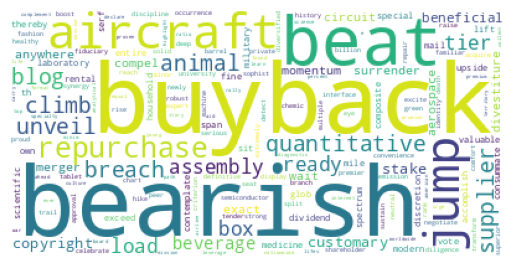

In [39]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

fq_pos = {df_words.final_word[k]: v for k, v in fq_pos.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_pos))
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

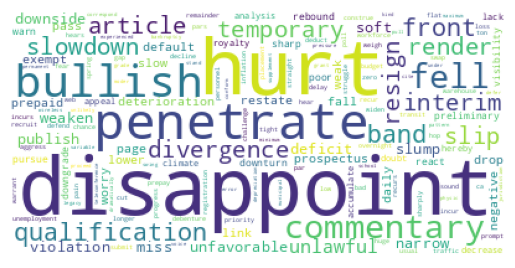

In [40]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
fq_neg = {df_words.final_word[k]: 1-v for k, v in fq_neg.items()}
        
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_neg))
plt.axis("off")

In [41]:
import numpy as np
import pandas as pd
import heapq
from tqdm import tqdm
import time
from sklearn import preprocessing
# d_pos = [list(df_words.TotalBodyNum)[i] for i in index_neg_word_xiu]
# d_neg =  [list(df_words.TotalBodyNum)[i] for i in index_neg_word_xiu]
WS_index = WS_pos_index + WS_neg_index

def SESTM2(W_train, r_train, WS_index):

    n, S = W_train.shape
    # n = len(W_train)
    # S = len(W_train[0])
    ############################Estimation Part ############################  
    r_order = np.argsort(r_train)+1
    phat = r_order/n # n
    
    s = np.zeros((n,S)) # construct a matrix only contains sentiment words
    s[:,WS_index] = W_train[:,WS_index]
    hhat = np.zeros((n,S)) 
    for i in range(n):
        if sum(s[i,:])!=0:
            hhat[i] = s[i,:]/sum(s[i,:])

    hhat = np.array(hhat) # specific sentiment word frequency in each article S x n
   
    Pmatrix = np.array([phat,1-phat])
    
    P_inverse = np.linalg.inv(Pmatrix @ Pmatrix.T) #2 x 2
    
    # estimated theta
    # Ohat = P_inverse @ Pmatrix @ hhat

    Ohat = hhat.T@ Pmatrix.T @P_inverse 
    
    Ohat[Ohat < 0] = 0
 
    Ohat = preprocessing.normalize(Ohat.T, norm='l1').T # S x 2
    return Ohat

Ohat = SESTM2(W_train, r_train, WS_index)

In [ ]:
[df_words.final_word[k] for k in np.nonzero(Ohat)[0]]

In [42]:

from scipy.optimize import minimize_scalar
def sentiment_score(W_test, Ohat, WS_index,lam):
    '''
    Input:
        W_test: Out-of-Sample sparse matrix
        Ohat: thetahat obtained from function sestm
        lam: lambda value
    Return:
        p_new: predicted sentiment score
    '''
    #test sample size
    n,S = W_test.shape  
    p_new = []
    # score each article's sentiment
    for i in tqdm(range(n)):   
        
        if not sum(W_test[i,WS_index]):   # no sentiment word found
            p_new.append(0.5)
        else:
            def pmle_objectfunction(X):
                # maxmize the object function
           
                # objfun = -np.sum(np.log(X * Ohat[WS_index][0]+ (1-X) * Ohat[WS_index][1])* W_test[i][WS_index] /np.sum(W_test[i,WS_index])) - lam * np.log(X*(1-X))
                objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in WS_index)/sum(W_test[i,WS_index])- lam * np.log(X*(1-X))
                
                return objfun
            solution = minimize_scalar(pmle_objectfunction, bounds=(0.0000001,0.9999999), method='bounded')
        
            # append sentiment score
            p_new.append(solution.x)
         
            # optimal_p = fminbound(lambda x: pmle_objectfunction(x),0,1)
            # print(optimal_p)
    return p_new

# p = sentiment_score(W_test, Ohat, WS_index,lam=1)

In [43]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools

# loss function of validation set

def Hyperparam(W_train, r_train, Lam, Alpha_posnum, Kappa):
    def L1_loss(p1, p2):
        return np.sum(np.abs(p1 - p2))
    L1 = 0
    for result in itertools.product(Lam, Alpha_posnum,Kappa):    
        print(result)
        lam = result[0]
        alpha_posnum = result[1]
        alpha_negnum = alpha_posnum
        kappa = result[2]
        ################################################################################################
        WS_pos_index,WS_neg_index,fq_pos,fq_neg= SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
        ws_index = WS_pos_index + WS_neg_index
        del fq_neg
        del fq_pos
        # ohat = SESTM2(W_train, r_train, ws_index)
        
        p = sentiment_score(W_train, Ohat, ws_index,lam)
        r_order = np.argsort(r_train) + 1
        phat = r_order/len(r_train) # n
        if  L1_loss(p, phat) > L1:
            L1 = L1_loss(p, phat)
            hyperparamerter = result
            # Ohat = ohat
            WS_index = ws_index
    return hyperparamerter,  WS_index

Lam = [ 1, 5, 10]
Alpha_posnum = [25, 50, 100]
Alpha_negnum = Alpha_posnum 
Kappa = [0.86,0.88,0.90,0.92,0.94]
(lam, alpha_posnum, kappa), WS_index = Hyperparam(W_vali, r_vali, Lam, Alpha_posnum, Kappa)

(1, 25, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687]
[0.42487046632124353, 0.4253028263795424, 0.4337979094076655, 0.4342629482071713, 0.43596059113300495, 0.44025157232704404, 0.4476010101010101, 0.4485294117647059, 0.4515195369030391, 0.45409429280397023, 0.4553686934023286, 0.4558011049723757, 0.45618556701030927, 0.45770065075921906, 0.45849802371541504, 0.45884146341463417, 0.45897435897435895, 0.4600484261501211, 0.4603174603174603, 0.46153846153846156, 0.4616588419405321, 0.462046204

  0%|          | 0/108263 [00:00<?, ?it/s]/tmp/ipykernel_3020598/4020337188.py:24: RuntimeWarning: divide by zero encountered in log
  objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in WS_index)/sum(W_test[i,WS_index])- lam * np.log(X*(1-X))
/tmp/ipykernel_3020598/4020337188.py:24: RuntimeWarning: invalid value encountered in double_scalars
  objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in WS_index)/sum(W_test[i,WS_index])- lam * np.log(X*(1-X))
100%|██████████| 108263/108263 [03:20<00:00, 539.32it/s] 


(1, 25, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143]
[0.4253028263795424, 0.4337979094076655, 0.4342629482071713, 0.4476010101010101, 0.4515195369030391, 0.4553686934023286, 0.4558011049723757, 0.45884146341463417, 0.4616588419405321, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.4679376083188908, 0.46808510638297873, 0.46879535558780844, 0.4688, 0.46905537459283386, 0.46923076923076923, 0.4693200663349917, 0.46959459459459457, 0.46965317919075145, 0.469879518

100%|██████████| 108263/108263 [04:27<00:00, 405.06it/s]


(1, 25, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987]
[0.4342629482071713, 0.4476010101010101, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.46905537459283386, 0.47099311701081614, 0.47099311701081614, 0.47326732673267324, 0.47419354838709676, 0.4753908511870295, 0.4758364312267658, 0.47585669781931467, 0.4760892667375133, 0.4763231197771588, 0.47666971637694416, 0.4768921634293369, 0.477124183006536, 0.47720364741641336, 0.47724

100%|██████████| 108263/108263 [06:07<00:00, 294.50it/s]


(1, 25, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907]
[0.4342629482071713, 0.4476010101010101, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.4753908511870295, 0.4758364312267658, 0.4763231197771588, 0.4768921634293369, 0.477124183006536, 0.4772413793103448, 0.47844643619291505, 0.47883211678832116, 0.48169014084507045, 0.4822777454968042, 0.4835377663008393, 0.4853801169590643, 0.48544973544973546, 0.4855614973262032, 0.4870435806831567, 0.487062404870624, 0.48763474952441344, 0.4

100%|██████████| 108263/108263 [07:11<00:00, 250.64it/s]


(1, 25, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787]
[0.4666666666666667, 0.477124183006536, 0.47883211678832116, 0.4870435806831567, 0.488756148981026, 0.4900562851782364, 0.49037037037037035, 0.4906759047689246, 0.4912633058847158, 0.49221094754894956, 0.4929238985313752, 0.4934604904632153, 0.493747996152613, 0.4943599803825405, 0.49500535140920443, 0.4950921714148911, 0.4950938199345843, 0.4952338727554866, 0.4955456570155902, 0.49554716981132074, 0.4958105646630237, 0.

100%|██████████| 108263/108263 [09:05<00:00, 198.49it/s]


(1, 50, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5649867374005305, 0.5643044619422573, 0.5643044619422573, 0.5639686684073107, 0.5636729222520107, 0.5635593220338984, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.562358276643991, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5610687022900763, 0.5610328638497653, 0.5607675906183369, 0.5602503912363067, 0.5602294455066922, 0.56, 0.559931506849315, 0.5593667546174143

100%|██████████| 108263/108263 [10:55<00:00, 165.28it/s]


(1, 50, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143, 0.5577264653641207, 0.5575364667747164, 0.5569823434991974, 0.5565891472868217, 0.5554140127388535, 0.5553121577217963, 0.5549132947976878, 0.5542949756888168, 0.5539772727272727, 0.5539000876424189, 0.5533536585365854, 0.553012048192771, 0.5529411764705883, 0.5523329129886507, 0.5520770620108368, 0.5519287833827893, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540

100%|██████████| 108263/108263 [14:00<00:00, 128.82it/s]


(1, 50, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987, 0.5480580619850922, 0.5480132450331126, 0.5471698113207547, 0.5471389645776567, 0.5470171890798786, 0.5465768799102132, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.5460674157303371, 0.546041055718475, 0.546, 0.5459579180509413, 0.5458377239199157, 0.5458333333333333, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5451873622336517, 0.54517611026

100%|██████████| 108263/108263 [16:51<00:00, 106.99it/s]


(1, 50, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907, 0.5436953807740325, 0.5425563030125767, 0.5423023578363384, 0.5421903052064632, 0.5419847328244275, 0.541871921182266, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.5409004438807863, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399802566633761, 0.5399477806788512, 0.5398608881754949, 0.539799331103679, 0.5396014307613695, 0.5395284327323162, 0.5394858272907054, 0.5394833272

100%|██████████| 108263/108263 [20:06<00:00, 89.71it/s] 


(1, 50, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787, 0.5390683696468821, 0.5387931034482759, 0.5384400335476657, 0.5383115073836723, 0.538308852719333, 0.5381199111769059, 0.5380077149988655, 0.5376016260162602, 0.5373189751206833, 0.5373189751206833, 0.5372340425531915, 0.5366731248270136, 0.5366161616161617, 0.5364071554547745, 0.5362049758633495, 0.5361726954492415, 0.5361688916485563, 0.5359005214600883, 0.5358481724461106, 0.535667107001321, 0.5355944837868059, 0.53548

100%|██████████| 108263/108263 [22:05<00:00, 81.67it/s] 


(1, 100, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5649867374005305, 0.5643044619422573, 0.5643044619422573, 0.5639686684073107, 0.5636729222520107, 0.5635593220338984, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.562358276643991, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5610687022900763, 0.5610328638497653, 0.5607675906183369, 0.5602503912363067, 0.5602294455066922, 0.56, 0.559931506849315, 0.559366754617414

100%|██████████| 108263/108263 [32:31<00:00, 55.47it/s] 


(1, 100, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143, 0.5577264653641207, 0.5575364667747164, 0.5569823434991974, 0.5565891472868217, 0.5554140127388535, 0.5553121577217963, 0.5549132947976878, 0.5542949756888168, 0.5539772727272727, 0.5539000876424189, 0.5533536585365854, 0.553012048192771, 0.5529411764705883, 0.5523329129886507, 0.5520770620108368, 0.5519287833827893, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.550973654

100%|██████████| 108263/108263 [39:13<00:00, 46.01it/s] 


(1, 100, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987, 0.5480580619850922, 0.5480132450331126, 0.5471698113207547, 0.5471389645776567, 0.5470171890798786, 0.5465768799102132, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.5460674157303371, 0.546041055718475, 0.546, 0.5459579180509413, 0.5458377239199157, 0.5458333333333333, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5451873622336517, 0.5451761102

100%|██████████| 108263/108263 [43:39<00:00, 41.32it/s] 


(1, 100, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907, 0.5436953807740325, 0.5425563030125767, 0.5423023578363384, 0.5421903052064632, 0.5419847328244275, 0.541871921182266, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.5409004438807863, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399802566633761, 0.5399477806788512, 0.5398608881754949, 0.539799331103679, 0.5396014307613695, 0.5395284327323162, 0.5394858272907054, 0.539483327

100%|██████████| 108263/108263 [45:43<00:00, 39.46it/s] 


(1, 100, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787, 0.5390683696468821, 0.5387931034482759, 0.5384400335476657, 0.5383115073836723, 0.538308852719333, 0.5381199111769059, 0.5380077149988655, 0.5376016260162602, 0.5373189751206833, 0.5373189751206833, 0.5372340425531915, 0.5366731248270136, 0.5366161616161617, 0.5364071554547745, 0.5362049758633495, 0.5361726954492415, 0.5361688916485563, 0.5359005214600883, 0.5358481724461106, 0.535667107001321, 0.5355944837868059, 0.5354

100%|██████████| 108263/108263 [50:33<00:00, 35.69it/s] 


(5, 25, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687]
[0.42487046632124353, 0.4253028263795424, 0.4337979094076655, 0.4342629482071713, 0.43596059113300495, 0.44025157232704404, 0.4476010101010101, 0.4485294117647059, 0.4515195369030391, 0.45409429280397023, 0.4553686934023286, 0.4558011049723757, 0.45618556701030927, 0.45770065075921906, 0.45849802371541504, 0.45884146341463417, 0.45897435897435895, 0.4600484261501211, 0.4603174603174603, 0.46153846153846156, 0.4616588419405321, 0.462046204

100%|██████████| 108263/108263 [03:39<00:00, 494.28it/s]


(5, 25, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143]
[0.4253028263795424, 0.4337979094076655, 0.4342629482071713, 0.4476010101010101, 0.4515195369030391, 0.4553686934023286, 0.4558011049723757, 0.45884146341463417, 0.4616588419405321, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.4679376083188908, 0.46808510638297873, 0.46879535558780844, 0.4688, 0.46905537459283386, 0.46923076923076923, 0.4693200663349917, 0.46959459459459457, 0.46965317919075145, 0.469879518

100%|██████████| 108263/108263 [04:18<00:00, 418.15it/s]


(5, 25, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987]
[0.4342629482071713, 0.4476010101010101, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.46905537459283386, 0.47099311701081614, 0.47099311701081614, 0.47326732673267324, 0.47419354838709676, 0.4753908511870295, 0.4758364312267658, 0.47585669781931467, 0.4760892667375133, 0.4763231197771588, 0.47666971637694416, 0.4768921634293369, 0.477124183006536, 0.47720364741641336, 0.47724

100%|██████████| 108263/108263 [06:06<00:00, 295.56it/s]


(5, 25, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907]
[0.4342629482071713, 0.4476010101010101, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.4753908511870295, 0.4758364312267658, 0.4763231197771588, 0.4768921634293369, 0.477124183006536, 0.4772413793103448, 0.47844643619291505, 0.47883211678832116, 0.48169014084507045, 0.4822777454968042, 0.4835377663008393, 0.4853801169590643, 0.48544973544973546, 0.4855614973262032, 0.4870435806831567, 0.487062404870624, 0.48763474952441344, 0.4

100%|██████████| 108263/108263 [07:10<00:00, 251.25it/s]


(5, 25, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787]
[0.4666666666666667, 0.477124183006536, 0.47883211678832116, 0.4870435806831567, 0.488756148981026, 0.4900562851782364, 0.49037037037037035, 0.4906759047689246, 0.4912633058847158, 0.49221094754894956, 0.4929238985313752, 0.4934604904632153, 0.493747996152613, 0.4943599803825405, 0.49500535140920443, 0.4950921714148911, 0.4950938199345843, 0.4952338727554866, 0.4955456570155902, 0.49554716981132074, 0.4958105646630237, 0.

100%|██████████| 108263/108263 [09:03<00:00, 199.29it/s]


(5, 50, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5649867374005305, 0.5643044619422573, 0.5643044619422573, 0.5639686684073107, 0.5636729222520107, 0.5635593220338984, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.562358276643991, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5610687022900763, 0.5610328638497653, 0.5607675906183369, 0.5602503912363067, 0.5602294455066922, 0.56, 0.559931506849315, 0.5593667546174143

100%|██████████| 108263/108263 [10:49<00:00, 166.60it/s]


(5, 50, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143, 0.5577264653641207, 0.5575364667747164, 0.5569823434991974, 0.5565891472868217, 0.5554140127388535, 0.5553121577217963, 0.5549132947976878, 0.5542949756888168, 0.5539772727272727, 0.5539000876424189, 0.5533536585365854, 0.553012048192771, 0.5529411764705883, 0.5523329129886507, 0.5520770620108368, 0.5519287833827893, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540

100%|██████████| 108263/108263 [13:52<00:00, 130.00it/s]


(5, 50, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987, 0.5480580619850922, 0.5480132450331126, 0.5471698113207547, 0.5471389645776567, 0.5470171890798786, 0.5465768799102132, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.5460674157303371, 0.546041055718475, 0.546, 0.5459579180509413, 0.5458377239199157, 0.5458333333333333, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5451873622336517, 0.54517611026

100%|██████████| 108263/108263 [17:10<00:00, 105.08it/s]


(5, 50, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907, 0.5436953807740325, 0.5425563030125767, 0.5423023578363384, 0.5421903052064632, 0.5419847328244275, 0.541871921182266, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.5409004438807863, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399802566633761, 0.5399477806788512, 0.5398608881754949, 0.539799331103679, 0.5396014307613695, 0.5395284327323162, 0.5394858272907054, 0.5394833272

100%|██████████| 108263/108263 [19:36<00:00, 92.03it/s] 


(5, 50, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787, 0.5390683696468821, 0.5387931034482759, 0.5384400335476657, 0.5383115073836723, 0.538308852719333, 0.5381199111769059, 0.5380077149988655, 0.5376016260162602, 0.5373189751206833, 0.5373189751206833, 0.5372340425531915, 0.5366731248270136, 0.5366161616161617, 0.5364071554547745, 0.5362049758633495, 0.5361726954492415, 0.5361688916485563, 0.5359005214600883, 0.5358481724461106, 0.535667107001321, 0.5355944837868059, 0.53548

100%|██████████| 108263/108263 [22:12<00:00, 81.22it/s] 


(5, 100, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5649867374005305, 0.5643044619422573, 0.5643044619422573, 0.5639686684073107, 0.5636729222520107, 0.5635593220338984, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.562358276643991, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5610687022900763, 0.5610328638497653, 0.5607675906183369, 0.5602503912363067, 0.5602294455066922, 0.56, 0.559931506849315, 0.559366754617414

100%|██████████| 108263/108263 [33:00<00:00, 54.67it/s] 


(5, 100, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143, 0.5577264653641207, 0.5575364667747164, 0.5569823434991974, 0.5565891472868217, 0.5554140127388535, 0.5553121577217963, 0.5549132947976878, 0.5542949756888168, 0.5539772727272727, 0.5539000876424189, 0.5533536585365854, 0.553012048192771, 0.5529411764705883, 0.5523329129886507, 0.5520770620108368, 0.5519287833827893, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.550973654

100%|██████████| 108263/108263 [38:57<00:00, 46.31it/s] 


(5, 100, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987, 0.5480580619850922, 0.5480132450331126, 0.5471698113207547, 0.5471389645776567, 0.5470171890798786, 0.5465768799102132, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.5460674157303371, 0.546041055718475, 0.546, 0.5459579180509413, 0.5458377239199157, 0.5458333333333333, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5451873622336517, 0.5451761102

100%|██████████| 108263/108263 [44:21<00:00, 40.68it/s] 


(5, 100, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907, 0.5436953807740325, 0.5425563030125767, 0.5423023578363384, 0.5421903052064632, 0.5419847328244275, 0.541871921182266, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.5409004438807863, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399802566633761, 0.5399477806788512, 0.5398608881754949, 0.539799331103679, 0.5396014307613695, 0.5395284327323162, 0.5394858272907054, 0.539483327

100%|██████████| 108263/108263 [46:37<00:00, 38.69it/s] 


(5, 100, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787, 0.5390683696468821, 0.5387931034482759, 0.5384400335476657, 0.5383115073836723, 0.538308852719333, 0.5381199111769059, 0.5380077149988655, 0.5376016260162602, 0.5373189751206833, 0.5373189751206833, 0.5372340425531915, 0.5366731248270136, 0.5366161616161617, 0.5364071554547745, 0.5362049758633495, 0.5361726954492415, 0.5361688916485563, 0.5359005214600883, 0.5358481724461106, 0.535667107001321, 0.5355944837868059, 0.5354

100%|██████████| 108263/108263 [50:43<00:00, 35.57it/s] 


(10, 25, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687]
[0.42487046632124353, 0.4253028263795424, 0.4337979094076655, 0.4342629482071713, 0.43596059113300495, 0.44025157232704404, 0.4476010101010101, 0.4485294117647059, 0.4515195369030391, 0.45409429280397023, 0.4553686934023286, 0.4558011049723757, 0.45618556701030927, 0.45770065075921906, 0.45849802371541504, 0.45884146341463417, 0.45897435897435895, 0.4600484261501211, 0.4603174603174603, 0.46153846153846156, 0.4616588419405321, 0.46204620

100%|██████████| 108263/108263 [03:30<00:00, 514.98it/s]


(10, 25, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143]
[0.4253028263795424, 0.4337979094076655, 0.4342629482071713, 0.4476010101010101, 0.4515195369030391, 0.4553686934023286, 0.4558011049723757, 0.45884146341463417, 0.4616588419405321, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.4679376083188908, 0.46808510638297873, 0.46879535558780844, 0.4688, 0.46905537459283386, 0.46923076923076923, 0.4693200663349917, 0.46959459459459457, 0.46965317919075145, 0.46987951

100%|██████████| 108263/108263 [04:26<00:00, 406.49it/s]


(10, 25, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987]
[0.4342629482071713, 0.4476010101010101, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.46905537459283386, 0.47099311701081614, 0.47099311701081614, 0.47326732673267324, 0.47419354838709676, 0.4753908511870295, 0.4758364312267658, 0.47585669781931467, 0.4760892667375133, 0.4763231197771588, 0.47666971637694416, 0.4768921634293369, 0.477124183006536, 0.47720364741641336, 0.4772

100%|██████████| 108263/108263 [06:06<00:00, 295.55it/s]


(10, 25, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907]
[0.4342629482071713, 0.4476010101010101, 0.46204620462046203, 0.4666666666666667, 0.46783216783216786, 0.4753908511870295, 0.4758364312267658, 0.4763231197771588, 0.4768921634293369, 0.477124183006536, 0.4772413793103448, 0.47844643619291505, 0.47883211678832116, 0.48169014084507045, 0.4822777454968042, 0.4835377663008393, 0.4853801169590643, 0.48544973544973546, 0.4855614973262032, 0.4870435806831567, 0.487062404870624, 0.48763474952441344, 0.

100%|██████████| 108263/108263 [07:16<00:00, 248.23it/s]


(10, 25, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787]
[0.4666666666666667, 0.477124183006536, 0.47883211678832116, 0.4870435806831567, 0.488756148981026, 0.4900562851782364, 0.49037037037037035, 0.4906759047689246, 0.4912633058847158, 0.49221094754894956, 0.4929238985313752, 0.4934604904632153, 0.493747996152613, 0.4943599803825405, 0.49500535140920443, 0.4950921714148911, 0.4950938199345843, 0.4952338727554866, 0.4955456570155902, 0.49554716981132074, 0.4958105646630237, 0

100%|██████████| 108263/108263 [09:15<00:00, 195.06it/s]


(10, 50, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5649867374005305, 0.5643044619422573, 0.5643044619422573, 0.5639686684073107, 0.5636729222520107, 0.5635593220338984, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.562358276643991, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5610687022900763, 0.5610328638497653, 0.5607675906183369, 0.5602503912363067, 0.5602294455066922, 0.56, 0.559931506849315, 0.559366754617414

100%|██████████| 108263/108263 [10:50<00:00, 166.46it/s]


(10, 50, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143, 0.5577264653641207, 0.5575364667747164, 0.5569823434991974, 0.5565891472868217, 0.5554140127388535, 0.5553121577217963, 0.5549132947976878, 0.5542949756888168, 0.5539772727272727, 0.5539000876424189, 0.5533536585365854, 0.553012048192771, 0.5529411764705883, 0.5523329129886507, 0.5520770620108368, 0.5519287833827893, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.550973654

100%|██████████| 108263/108263 [13:39<00:00, 132.06it/s]


(10, 50, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987, 0.5480580619850922, 0.5480132450331126, 0.5471698113207547, 0.5471389645776567, 0.5470171890798786, 0.5465768799102132, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.5460674157303371, 0.546041055718475, 0.546, 0.5459579180509413, 0.5458377239199157, 0.5458333333333333, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5451873622336517, 0.5451761102

100%|██████████| 108263/108263 [16:24<00:00, 110.01it/s]


(10, 50, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907, 0.5436953807740325, 0.5425563030125767, 0.5423023578363384, 0.5421903052064632, 0.5419847328244275, 0.541871921182266, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.5409004438807863, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399802566633761, 0.5399477806788512, 0.5398608881754949, 0.539799331103679, 0.5396014307613695, 0.5395284327323162, 0.5394858272907054, 0.539483327

100%|██████████| 108263/108263 [19:04<00:00, 94.62it/s] 


(10, 50, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787, 0.5390683696468821, 0.5387931034482759, 0.5384400335476657, 0.5383115073836723, 0.538308852719333, 0.5381199111769059, 0.5380077149988655, 0.5376016260162602, 0.5373189751206833, 0.5373189751206833, 0.5372340425531915, 0.5366731248270136, 0.5366161616161617, 0.5364071554547745, 0.5362049758633495, 0.5361726954492415, 0.5361688916485563, 0.5359005214600883, 0.5358481724461106, 0.535667107001321, 0.5355944837868059, 0.5354

100%|██████████| 108263/108263 [21:44<00:00, 82.98it/s] 


(10, 100, 0.86)
377.0
377.0
3257
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.6138392857142857, 0.5968688845401174, 0.5941644562334217, 0.5831842576028623, 0.5826771653543307, 0.5797373358348968, 0.5793103448275863, 0.5785797438882422, 0.5780933062880325, 0.577639751552795, 0.5772251308900523, 0.5771428571428572, 0.575107296137339, 0.5746691871455577, 0.5743801652892562, 0.5734597156398105, 0.5734375, 0.573015873015873, 0.5703883495145631, 0.5696887686062246, 0.5691275167785235, 0.5675, 0.5669099756690997, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5649867374005305, 0.5643044619422573, 0.5643044619422573, 0.5639686684073107, 0.5636729222520107, 0.5635593220338984, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.562358276643991, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5610687022900763, 0.5610328638497653, 0.5607675906183369, 0.5602503912363067, 0.5602294455066922, 0.56, 0.559931506849315, 0.55936675461741

100%|██████████| 108263/108263 [32:50<00:00, 54.95it/s] 


(10, 100, 0.88)
554.0
554.0
2791
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5831842576028623, 0.5785797438882422, 0.5772251308900523, 0.5734375, 0.573015873015873, 0.5696887686062246, 0.5691275167785235, 0.56657223796034, 0.5659411011523687, 0.5651629072681704, 0.5651074589127687, 0.5636729222520107, 0.5633561643835616, 0.5633270321361059, 0.5628140703517588, 0.5623376623376624, 0.5619469026548672, 0.5611967361740707, 0.5602503912363067, 0.5602294455066922, 0.559931506849315, 0.5593607305936074, 0.5586666666666666, 0.5585874799357945, 0.5580357142857143, 0.5577264653641207, 0.5575364667747164, 0.5569823434991974, 0.5565891472868217, 0.5554140127388535, 0.5553121577217963, 0.5549132947976878, 0.5542949756888168, 0.5539772727272727, 0.5539000876424189, 0.5533536585365854, 0.553012048192771, 0.5529411764705883, 0.5523329129886507, 0.5520770620108368, 0.5519287833827893, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.55097365

100%|██████████| 108263/108263 [38:22<00:00, 47.02it/s] 


(10, 100, 0.9)
856.7000000000007
856.7000000000007
2325
pi 0.523549134976862
hi 0.5102339181286549 698 1368
[0.5785797438882422, 0.5636729222520107, 0.5633270321361059, 0.5611967361740707, 0.5602294455066922, 0.5593607305936074, 0.5553121577217963, 0.5539772727272727, 0.5539000876424189, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.551762114537445, 0.5516209476309227, 0.5512600229095075, 0.5510440835266821, 0.5509736540664376, 0.5506458191706323, 0.550561797752809, 0.5505263157894736, 0.5502958579881657, 0.5498676081200353, 0.549558390578999, 0.5491774588729437, 0.5480943738656987, 0.5480580619850922, 0.5480132450331126, 0.5471698113207547, 0.5471389645776567, 0.5470171890798786, 0.5465768799102132, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.5460674157303371, 0.546041055718475, 0.546, 0.5459579180509413, 0.5458377239199157, 0.5458333333333333, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5451873622336517, 0.545176110

100%|██████████| 108263/108263 [43:01<00:00, 41.93it/s] 


(10, 100, 0.92)
1394.0
1394.0
1861
pi 0.523549134976862
[0.5636729222520107, 0.5529411764705883, 0.5520770620108368, 0.551826994780015, 0.5516209476309227, 0.5512600229095075, 0.5506458191706323, 0.5491774588729437, 0.5480580619850922, 0.5471698113207547, 0.5471389645776567, 0.5465717981888745, 0.546284224250326, 0.5462068965517242, 0.5461432506887053, 0.546041055718475, 0.545823927765237, 0.5457705677867902, 0.5456171735241503, 0.5449817992719709, 0.5449817992719709, 0.5446531238022231, 0.5443902439024391, 0.5442661913250149, 0.5438144329896907, 0.5436953807740325, 0.5425563030125767, 0.5423023578363384, 0.5421903052064632, 0.5419847328244275, 0.541871921182266, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.5409004438807863, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399802566633761, 0.5399477806788512, 0.5398608881754949, 0.539799331103679, 0.5396014307613695, 0.5395284327323162, 0.5394858272907054, 0.53948332

100%|██████████| 108263/108263 [45:45<00:00, 39.43it/s] 


(10, 100, 0.94)
2407.679999999993
2407.679999999993
1395
pi 0.523549134976862
[0.551826994780015, 0.5512600229095075, 0.5491774588729437, 0.5480580619850922, 0.5465717981888745, 0.5457705677867902, 0.5446531238022231, 0.5443902439024391, 0.5438144329896907, 0.5425563030125767, 0.5415708182714426, 0.5413588033879978, 0.5409781338674678, 0.540757954951734, 0.5404941660947151, 0.5404369490226141, 0.5402902130287126, 0.5401069518716578, 0.5399477806788512, 0.5395284327323162, 0.5394858272907054, 0.5394833272260902, 0.5394574599260172, 0.5394190871369294, 0.5393347412882787, 0.5390683696468821, 0.5387931034482759, 0.5384400335476657, 0.5383115073836723, 0.538308852719333, 0.5381199111769059, 0.5380077149988655, 0.5376016260162602, 0.5373189751206833, 0.5373189751206833, 0.5372340425531915, 0.5366731248270136, 0.5366161616161617, 0.5364071554547745, 0.5362049758633495, 0.5361726954492415, 0.5361688916485563, 0.5359005214600883, 0.5358481724461106, 0.535667107001321, 0.5355944837868059, 0.535

100%|██████████| 108263/108263 [49:43<00:00, 36.29it/s] 


(-0.5, 399.5, 199.5, -0.5)

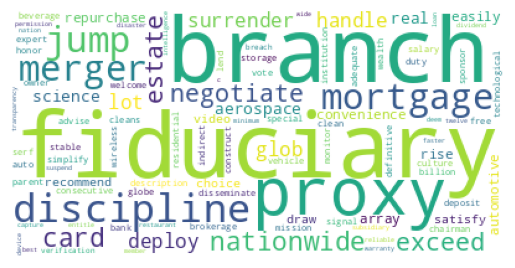

In [54]:
fq_pos,fq_neg ={},{}
for i in WS_index[:100]:
    i_index = np.nonzero(W_vali[:,i])[0] # count of word i appearance in all article
    num_i_index = len(i_index)
    f_r = sum(r_vali[i_index]>0) 
    fq_pos[i] = f_r/num_i_index

for i in WS_index[100:]:
    i_index = np.nonzero(W_vali[:,i])[0] # count of word i appearance in all article
    num_i_index = len(i_index)
    f_r = sum(r_vali[i_index]>0) 
    fq_neg[i] = f_r/num_i_index

fq_pos = {df_words.final_word[k]: v for k, v in fq_pos.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_pos))
plt.axis("off")    

(-0.5, 399.5, 199.5, -0.5)

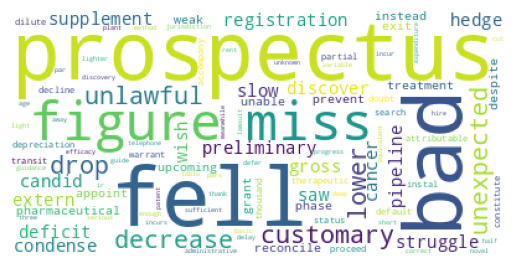

In [55]:
fq_neg = {df_words.final_word[k]: 1-v for k, v in fq_neg.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_neg))
plt.axis("off")    